In [2]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import cm as cmaps
import healpy as hp
from tqdm.notebook import tqdm
import torch
import torch.nn as nn

from scipy.stats import chi2
from scipy.stats import norm

from plot_params import params
from simulation.astrometry_sim import QuasarSim
from theory.units import *
from theory.limit import get_lim

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

/var/folders/d8/fkpry78n5tz_ztp9lvhv88fm0000gn/T/ipykernel_38588/940257387.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [3]:
from plot_params import params
import matplotlib.pylab as pylab

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

alpha_plot = 1.
lw_plot = 2.5


## Basline analysis

In [4]:
import sbi.utils as utils
import mlflow

run_id = '1936d60ac8f945b4b6873c96a4946f32'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-astrometry/data/logs/mlruns/0/' + run_id + '/artifacts/density_estimator')

2021/12/10 10:06:54 WARNING mlflow.pytorch: Stored model version '1.8.1' does not match installed PyTorch version '1.10.0'
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:76: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:76: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.8/site-packages/PyGSP-0.5.1-py3.8.egg/pygsp/filters/simpletight.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?


PyTorch Geometric not importable


In [5]:
Sigma_q = 1e8 / (4 * np.pi)
pixarea = hp.nside2pixarea(nside=64, degrees=False)
N_q_pix = Sigma_q * pixarea

In [6]:
max_sep = 25
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

In [15]:
sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=200., alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

sim.analysis_pipeline(get_sample=True)

Simulating 1557 subhalos between 7.0 and 10.0


In [7]:
list(density_estimator.children())[0].add_noise.sigma = 0.

In [8]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
    """
    def __init__(self, sigma=0.):
        super().__init__()
        self.sigma = sigma
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        if self.sigma != 0.:
            sampled_noise = self.noise.expand(*x.size()).detach().float().normal_() * self.sigma
            x = x + sampled_noise
        return x 
    
class BandMask(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
    """
    def __init__(self, mask=None):
        super().__init__()
        self.mask = mask
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        if self.mask is not None:
            x[:, self.mask.long()] = 0.
        return x 

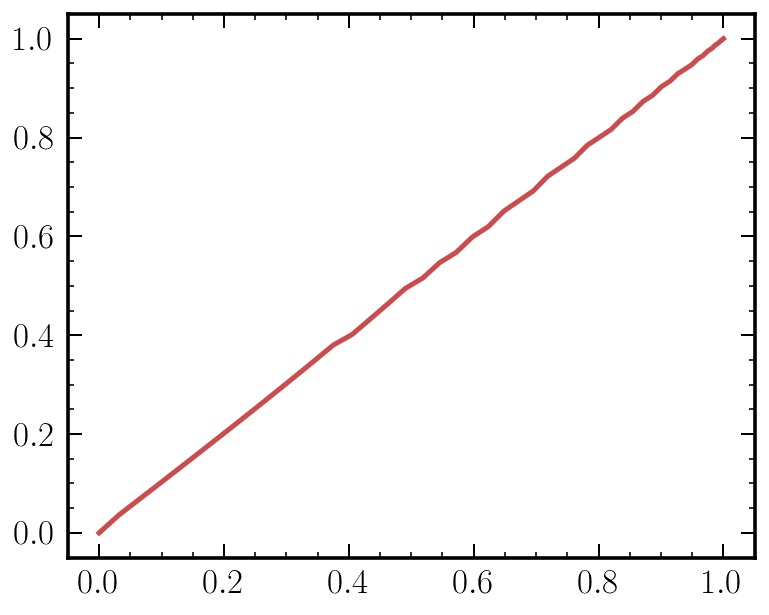

In [10]:
from simulation import create_mask as cm

f_sky = []
band_mask_list = np.linspace(0, 90)
for band_mask in band_mask_list:
    mask = ~cm.make_mask_total(band_mask=True, band_mask_range=band_mask, nside=64)
    f_sky.append(np.sum(~mask) / hp.nside2npix(64))
plt.plot((np.sin(np.deg2rad(band_mask_list))), f_sky)

In [11]:
list(density_estimator.children())[0].embedding_net_y

SphericalGraphCNN(
  (activation_function): ReLU()
  (layer_0): SphericalChebBNPool(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
    (pooling): HealpixMaxPool(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_1): SphericalChebBNPool(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
    (pooling): HealpixMaxPool(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_2): SphericalChebBNPool(
    (spherical_cheb): SphericalChebConv(
      (chebconv): ChebConv()
    )
    (pooling): HealpixMaxPool(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_3): SphericalChebBNPoo

In [12]:
nside_max = 64
nside_list = [int(nside_max / (2 ** i)) for i in np.arange(hp.nside2order(nside_max))]
int(hp.nside2npix(nside_list[-1]) / 4)

12

In [13]:
nside_list

[64, 32, 16, 8, 4, 2]

In [23]:
np.rad2deg(np.arcsin(0.5))

29.999999999999996

In [21]:
(x_test[0, :, 0] != 0).sum() / hp.nside2npix(64)

tensor(0.7671)

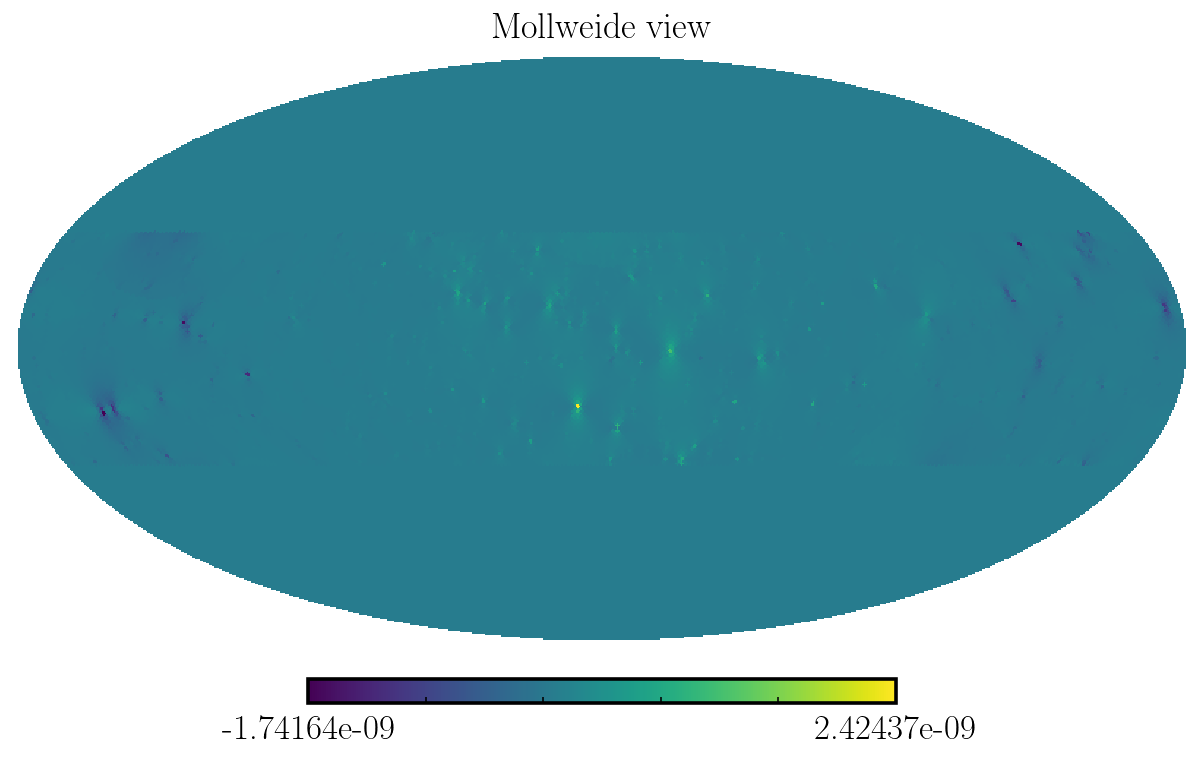

In [24]:
from simulation import create_mask as cm

mask = ~cm.make_mask_total(band_mask = True, band_mask_range=30, nside=64)
mask = hp.reorder(mask, r2n=True)
mask = torch.Tensor(mask).bool()

x_test = torch.Tensor(hp.reorder(sim.mu_qsrs.T, r2n=True)).T.unsqueeze(0)
x_test[:, mask, :] = 0.

hp.mollview(x_test[0, :, 0], nest=True)

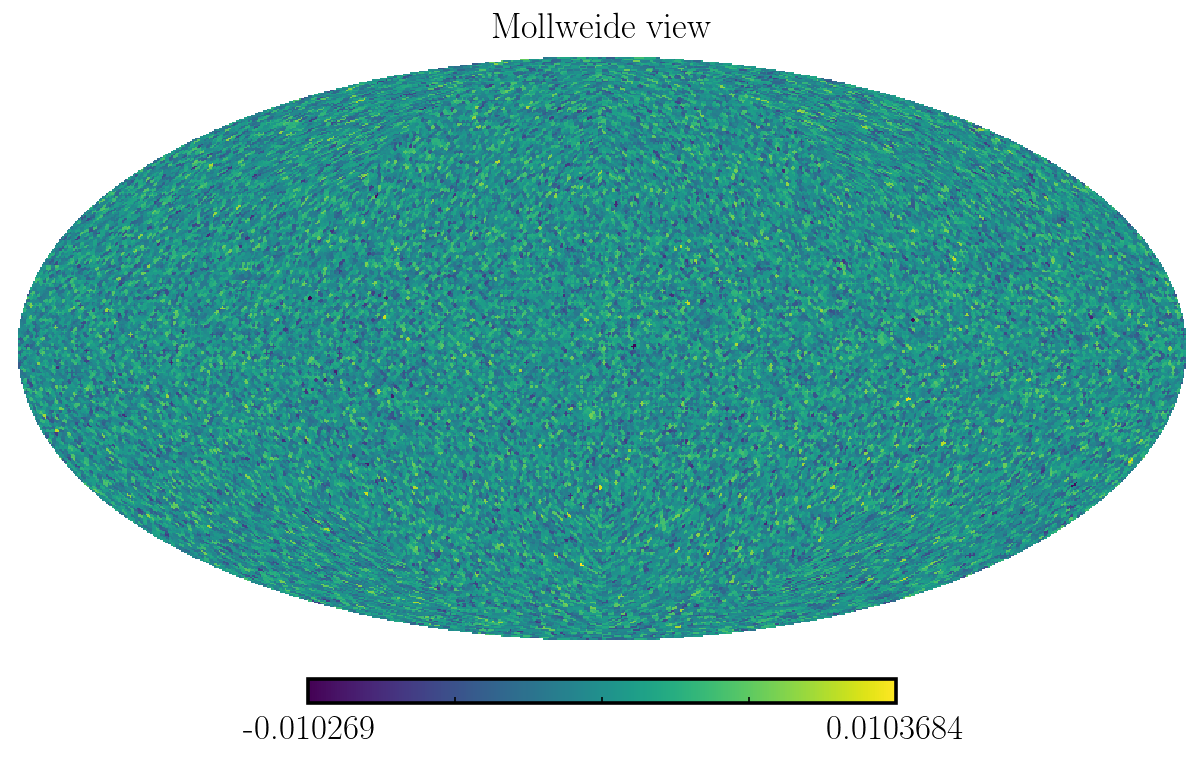

In [9]:
x_test = torch.Tensor(sim.mu_qsrs)

# Add noise
gn = GaussianNoise(sigma=0.0023)
x_test = gn(x_test).T

hp.mollview(x_test[0])

In [1]:
n_trials = 1  # Number of samples to simulate
n_test = 1  # Number of points in f_sub over which to compute likelihood ratio

out = np.zeros((n_trials, n_test))

for i_trial in tqdm(range(n_trials)):
    
    # Simulate subhalos and make astrometric map
    sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=150., alpha=-1.9)
    sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
    sim.set_subhalo_properties(sim.c200_SCP, distdep=False)
    
    sim.analysis_pipeline(get_sample=True)
    sim.mu_qsrs = 1e6 * hp.reorder(sim.mu_qsrs.T, r2n=True).T
    
    x_test = torch.Tensor(sim.mu_qsrs)
    
    # Add noise
    gn = GaussianNoise(sigma=0.0023)
    x_test = gn(x_test).T
    
    theta_test = torch.linspace(1., 300., n_test).unsqueeze(1)

    # Compute LLR over the parameter grid
    out[i_trial, :] = [density_estimator(x_test.unsqueeze(0), theta_test[i].unsqueeze(0)).squeeze().detach().numpy() \
           for i in (range(n_test))]

NameError: name 'np' is not defined